In [2]:
# импортируем необходимые библиотеки, классы и функции
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import graphviz
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.tree import export_graphviz

In [18]:
# загружаем данные для регрессии
data = pd.read_csv('regression.csv', sep=';')
# выводим датафрейм
data

,age,days_of_delinq
0,23,6
1,45,8
2,44,10
3,20,12
4,49,15
5,56,10
6,55,14
7,43,20
8,23,11
9,67,6


In [19]:
# создаем массив меток зависимой переменной
y = data.pop('days_of_delinq').values
# создаем метки признаков, это нам пригодится потом
# для отрисовки дерева
feat_labels = data.columns
# создаем массив признаков
X = data.values

In [23]:
# создаем класс градиентного бустинга для задачи регрессии с использованием функции потерь Хьюбера
class SimpleGradientBoostingRegressorHuber(BaseEstimator):

    # пишем функцию, вычисляющую антиградиент
    # функции потерь Хьюбера
    def huber_antigradient(self, y_hat, y_true, ath_quantile):
        # определяем значение delta_huber как квантиль уровня ath_quantile модуля разности y_true и y_hat
        delta_huber = np.quantile(abs(y_true - y_hat), ath_quantile)
        # считаем антиградиент по формуле из учебника на странице 360 TABLE 10.2.
        # https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print12.pdf
        huber_vector = np.where(abs(y_true - y_hat) <= delta_huber,
                                y_true - y_hat,
                                delta_huber * np.sign(y_true - y_hat))
        return huber_vector

    def __init__(self, n_estimators=100, learning_rate=0.1,
                 max_depth=3, random_state=17, debug=True, ath_quantile=0.90):
        """
        n_estimators - количество итераций;
        learning_rate - темп обучения;
        max_depth - глубина дерева;
        random_state - стартовое значение генератора псевдослучайных чисел;
        debug – информация для отладки алгоритма;
        ath_quantile - квантиль порядка alpha для функции потерь Хьюбера (0 <= ath_quantile <= 1)
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.debug = debug
        self.objective = mean_squared_error
        self.ath_quantile = ath_quantile
        
        # создаем пустые списки, здесь будем хранить наши модели-деревья
        # и значения функции потерь
        self.trees = []
        self.loss_by_iter = []
        
        # для отладки будем хранить псевдоостатки и прогнозы
        # по каждой итерации
        if self.debug:
            self.pseudoresiduals = []
            self.temp_pred = []
        
    def fit(self, X, y):
        # изначально все предсказания 0
        prediction = 0  
        for iter_num in range(self.n_estimators):
            # вычисляем псевдо-остатки
            pseudoresid = self.huber_antigradient(prediction, y, self.ath_quantile)
            
            # чтобы разобраться с алгоритмом на игрушечных примерах (debug=True),
            # будем смотреть на псевдо-остатки (антиградиент) на каждой итерации
            if self.debug:    
                self.pseudoresiduals.append(pseudoresid)
                
            # создаем экземпляр класса DecisionTreeRegressor
            tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                         random_state=self.random_state)
            
            # обучаем дерево-регрессор на псевдо-остатках
            tree.fit(X, pseudoresid)
            
            # вычисляем прогнозы
            pred = tree.predict(X)
            
            # для отладки может пригодится прогноз на каждой итерации
            if self.debug: 
                self.temp_pred.append(pred)
                
            # добавляем дерево в список деревьев  
            self.trees.append(tree)
            
            # обновляем спрогнозированное значение зависимой переменной,
            # которое потребуется для вычисления остатка
            prediction += self.learning_rate * pred
            
            # добавляем значение функции потерь в список значений
            self.loss_by_iter.append(self.objective(y, prediction))
        
        return self
    
    def predict(self, X):
        # изначально все предсказания 0
        pred = np.zeros(X.shape[0])
        for iter_num in range(self.n_estimators):
            # складываем все прогнозы деревьев с весом self.learning_rate
            pred += self.learning_rate * self.trees[iter_num].predict(X)
            
        return pred

In [24]:
# создаем экземпляр класса SimpleGradientBoostingRegressorHuber
boost = SimpleGradientBoostingRegressorHuber(n_estimators=20, 
                                             learning_rate=0.6,
                                             max_depth=4, 
                                             random_state=42, 
                                             ath_quantile=0.8)
# обучаем модель
boost.fit(X, y)
# получаем прогнозы
pred = boost.predict(X)

In [25]:
print('R-квадрат', r2_score(y, pred))
print('RMSE', np.sqrt(mean_squared_error(y, pred)))
print('MSE', mean_squared_error(y, pred))

R-квадрат 0.9245878278695525
RMSE 1.1242366320780954
MSE 1.2639080049062987


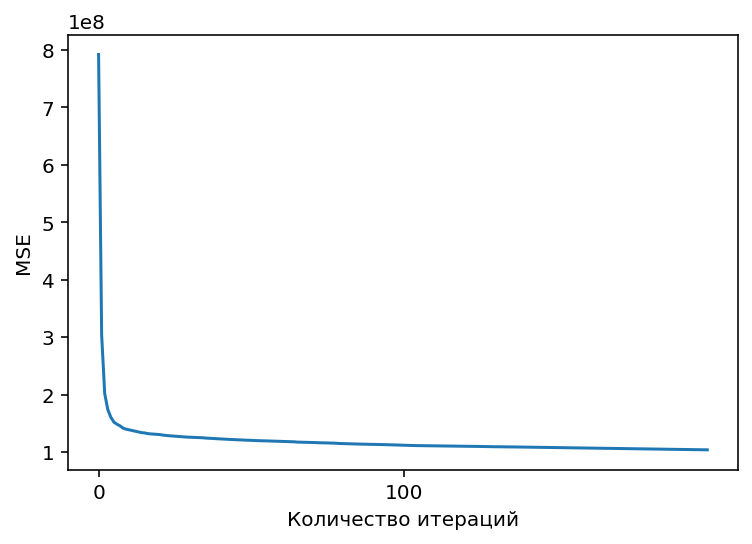

In [10]:
# построим график изменения квадратичной функции потерь
plt.plot(range(len(boost.loss_by_iter)), boost.loss_by_iter)
plt.xticks(np.arange(0, 200, step=100))
plt.xlabel('Количество итераций')
plt.ylabel('MSE')
plt.show()

# Пробуем на реальном примере данных

In [35]:
# загружаем данные для регрессии
data = pd.read_csv('Flats_missing.csv', sep=';', decimal=',')
# выводим датафрейм
data

,Rooms_Number,District,Stor,Storeys,Space_Total,Space_Living,Space_Kitchen,Balcon_Num,Lodgee_Num,lat,Long,Cost_KV
0,1,Заельцовский,13,17.0,54.10,18.00,21.20,0.0,1,55.0725,82.9069,50831.79298
1,1,Заельцовский,10,17.0,54.50,18.00,21.10,0.0,1,55.0725,82.9069,52000.00000
2,1,Центральный,8,17.0,37.00,0.00,0.00,0.0,0,55.0725,82.9068,87837.83784
3,1,Центральный,2,17.0,42.00,0.00,0.00,0.0,0,55.0725,82.9068,90238.09524
4,1,Центральный,13,17.0,28.00,0.00,0.00,0.0,0,55.0725,82.9068,110714.28570
...,...,...,...,...,...,...,...,...,...,...,...,...
71745,1,Ленинский,7,14.0,39.72,16.91,10.06,0.0,1,54.9784,82.8118,62940.58409
71746,1,Ленинский,4,14.0,41.60,15.70,10.00,0.0,1,54.9784,82.8118,44471.15385
71747,2,Ленинский,6,14.0,48.50,28.00,8.50,0.0,2,54.9784,82.8118,56907.21649
71748,1,Ленинский,14,14.0,27.00,0.00,0.00,0.0,0,54.9784,82.8118,51851.85185


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71750 entries, 0 to 71749
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms_Number   71750 non-null  int64  
 1   District       71740 non-null  object 
 2   Stor           71750 non-null  int64  
 3   Storeys        71746 non-null  float64
 4   Space_Total    71746 non-null  float64
 5   Space_Living   71747 non-null  float64
 6   Space_Kitchen  71749 non-null  float64
 7   Balcon_Num     71749 non-null  float64
 8   Lodgee_Num     71750 non-null  int64  
 9   lat            71750 non-null  float64
 10  Long           71750 non-null  float64
 11  Cost_KV        71750 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 6.6+ MB


In [37]:
from sklearn.preprocessing import LabelEncoder
data['District'] = LabelEncoder().fit_transform(data['District'].astype(str))

In [38]:
data = data.fillna(0)

In [39]:
# создаем массив меток зависимой переменной
y = data.pop('Cost_KV').values
# создаем метки признаков, это нам пригодится потом
# для отрисовки дерева
feat_labels = data.columns
# создаем массив признаков
X = data.values

In [42]:
# создаем экземпляр класса SimpleGradientBoostingRegressorHuber
boost = SimpleGradientBoostingRegressorHuber(n_estimators=200, 
                                             learning_rate=0.6,
                                             max_depth=4, 
                                             random_state=42, 
                                             ath_quantile=0.8)
# обучаем модель
boost.fit(X, y)
# получаем прогнозы
pred = boost.predict(X)

In [41]:
print('R-квадрат', r2_score(y, pred))
print('RMSE', np.sqrt(mean_squared_error(y, pred)))
print('MSE', mean_squared_error(y, pred))

R-квадрат 0.5550024460145622
RMSE 10352.912939326434
MSE 107182806.3292727


In [43]:
print('R-квадрат', r2_score(y, pred))
print('RMSE', np.sqrt(mean_squared_error(y, pred)))
print('MSE', mean_squared_error(y, pred))

R-квадрат 0.5682734731272745
RMSE 10197.368582037467
MSE 103986325.9979248
